# Instalacion e importacion de paquetes

In [232]:
import segyio

try:
    filename = 'Kerry3D.segy'
    with segyio.open(filename, ignore_geometry=True) as f:
        text_header = f.text[0]
        print(text_header)
except FileNotFoundError:
    print(f"Error: El archivo '{filename}' no se encontró.")
except Exception as e:
    print(f"Ocurrió un error al leer el encabezado: {e}")

bytearray(b'C01 AREA        : OFFSHORE TARANAKI - OFFSHORE TARANAKI SEISMIC DATABASE        C02 DESCRIPTION : KERRY3D SEISMIC COVERAGE - PHASE MATCHED IN GEOFRAME          C03 =========================================================================== C04 DATE     :1996       CLASS      :RAW MIGRATION /+90 DEGREE PHASE SHIFT      C05 OPERATOR :WMC        PROCESSING :DIGICON SINGAPORE                          C06 =========================================================================== C07 THE 3D DATA HAS BEEN DATUM AND PHASE SHIFTED. DATA HAS BEEN MERGED WITH     C08 CHECKED NAV AND EXPORTED FROM GEOFRAME 4.2 IN STANDARD SEGY.                C09 INLINES/SP RANGE :510-796 CDP INC       :1        SAMPLE INTERVAL :4000     C10 XLINES/CDP RANGE :58-792  SAMPLES/TRACE :1251     FINAL TIME :5000          C11 LINE INC      :1  TRACES/LINE   :VARIABLE IL/XL X/EAST Y/NORTH              C12 =========================================================================== C13 THIS DATASET WAS PREPARE

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage import uniform_filter1d
from scipy.signal import welch
import segyio
import pylops

import numpy as np
from scipy.ndimage import uniform_filter1d


# Lectura y visualizacion del SEGY

(np.float64(58.0), np.float64(792.0), np.float64(5004.0), np.float64(0.0))

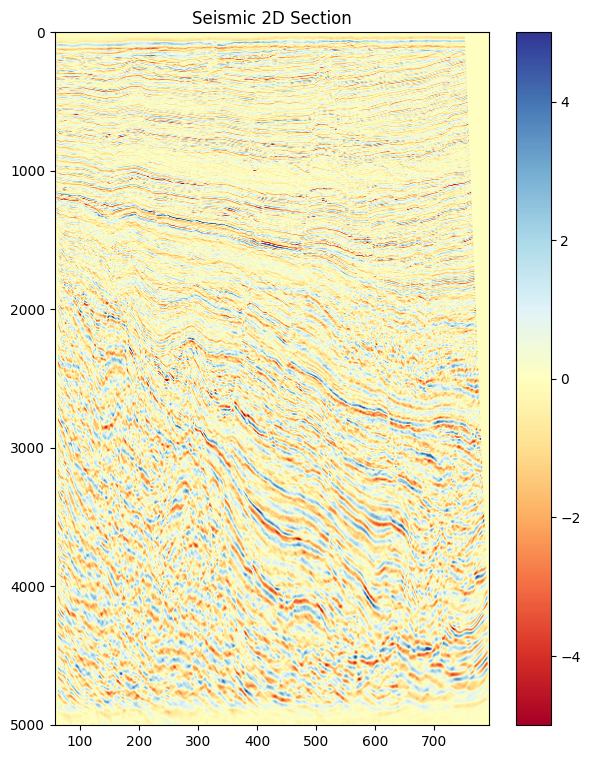

In [2]:
segyfile = 'Kerry3D.segy'

f = segyio.open(segyfile, iline=segyio.tracefield.TraceField.SourceEnergyDirectionExponent, 
                xline=segyio.tracefield.TraceField.CDP)

il, xl, t = f.ilines, f.xlines, f.samples
dt = t[1] - t[0]

d = segyio.cube(f)
nil, nxl, nt = d.shape

seismic2d = d[nil // 2]  # Extraemos una sección 2D

plt.figure(figsize=(7, 9))
plt.imshow(seismic2d.T, cmap='RdYlBu', vmin=-5, vmax=5,
           extent=(xl[0], xl[-1], t[-1], t[0]))
plt.title('Seismic 2D Section')
plt.colorbar()
plt.axis('tight')

## Sección de Cálculo de Atributos Sísmicos

En esta sección, se definen las funciones para calcular diversos atributos sísmicos a partir de los datos de la sísmica 2D (`seismic2d`). Estos atributos resaltan diferentes características de la señal sísmica, lo que puede ser útil para el análisis y la interpretación geológica.

A continuación, se presenta una tabla con una breve descripción de cada atributo y cómo se calcula:

| Atributo                     | Énfasis                                                                 | Cálculo                                                                                                                                                              |
|------------------------------|-------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Amplitud Instantánea         | La envolvente de la señal, relacionada con la intensidad de la reflexión. | Magnitud de la señal analítica obtenida mediante la Transformada de Hilbert.                                                                                       |
| Frecuencia Instantánea       | La tasa de cambio de la fase instantánea, relacionada con la estratigrafía. | Derivada temporal de la fase instantánea.                                                                                                                            |
| Amplitud RMS                 | Una medida de la energía promedio de la señal dentro de una ventana.     | Raíz cuadrada de la media cuadrática de la amplitud dentro de una ventana deslizante.                                                                              |
| Varianza Local               | La dispersión de la amplitud alrededor de su media local.                | Varianza de la amplitud calculada dentro de una ventana deslizante.                                                                                                |
| Tasa de Cruces por Cero      | La frecuencia con la que la señal cruza el nivel cero.                  | Promedio del número de veces que la señal cambia de signo dentro de una ventana deslizante.                                                                       |
| Entropía Espectral           | La irregularidad o el contenido armónico del espectro de frecuencia.   | Entropía de la densidad espectral de potencia (PSD) calculada dentro de una ventana deslizante utilizando la Transformada de Welch.                               |
| Gradiente de Amplitud        | La tasa de cambio de la amplitud a lo largo del tiempo.                 | Valor absoluto de la diferencia entre muestras de amplitud adyacentes (con la primera muestra duplicada al inicio).                                                 |
| Gradiente de Fase Instantánea| La tasa de cambio de la fase instantánea a lo largo del tiempo.         | Valor absoluto de la diferencia entre muestras de fase instantánea adyacentes (con la primera muestra duplicada al inicio).                                         |
| Mediana de Amplitud (Ventana)| El valor central de la amplitud dentro de una ventana.                  | Mediana de los valores absolutos de la amplitud calculada dentro de una ventana deslizante.                                                                         |
| Rango de Amplitud (Ventana)  | La diferencia entre el valor máximo y mínimo de la amplitud en una ventana. | Diferencia entre el valor máximo y el valor mínimo de la amplitud dentro de una ventana deslizante.                                                              |

In [233]:
def calculate_instantaneous_attributes(seismic):
    """Calcula Amplitud Instantánea y Frecuencia Instantánea."""
    analytic_signal = scipy.signal.hilbert(seismic, axis=0)
    instant_amp = np.abs(analytic_signal)
    instant_phase = np.unwrap(np.angle(analytic_signal), axis=0)
    instant_freq = np.diff(instant_phase, axis=0)
    instant_freq = np.vstack([instant_freq[0, :], instant_freq])  # mantener tamaño original
    return instant_amp, instant_freq

def calculate_rms_amplitude(seismic, window=25):
    """Calcula la Amplitud RMS."""
    return np.sqrt(uniform_filter1d(seismic**2, size=window, axis=0))

def calculate_local_variance(seismic, window=25):
    """Calcula la Varianza Local."""
    mean = uniform_filter1d(seismic, size=window, axis=0)
    sq_diff = (seismic - mean) ** 2
    return uniform_filter1d(sq_diff, size=window, axis=0)

def sliding_window_attribute(arr, func, window_size):
    """Aplica una función a ventanas deslizantes a lo largo del tiempo."""
    half = window_size // 2
    result = np.full_like(arr, np.nan, dtype=np.float32)
    for i in range(arr.shape[1]):  # por traza
        for j in range(half, arr.shape[0] - half):
            segment = arr[j - half:j + half + 1, i]
            result[j, i] = func(segment)
    return result

def calculate_zero_cross_rate(seismic, window_size=25):
    """Calcula la Tasa de Cruces por Cero usando una ventana deslizante."""
    def _zero_cross_rate(x):
        return np.mean(np.diff(np.signbit(x)) != 0)
    return sliding_window_attribute(seismic, _zero_cross_rate, window_size)

def calculate_spectral_entropy(seismic, window_size=25, nperseg=64):
    """Calcula la Entropía Espectral usando una ventana deslizante."""
    def _spectral_entropy(x):
        f, Pxx = welch(x, nperseg=nperseg, nfft=nperseg)
        Pxx = Pxx / np.sum(Pxx + 1e-12)  # normalizar
        return -np.sum(Pxx * np.log2(Pxx + 1e-12))
    return sliding_window_attribute(seismic, _spectral_entropy, window_size)

def calculate_gradient_amplitude(seismic):
    """Calcula el Gradiente de Amplitud a lo largo del tiempo."""
    return np.abs(np.diff(seismic, axis=0, prepend=seismic[[0], :]))

def calculate_gradient_phase(seismic):
    """Calcula el Gradiente de Fase Instantánea a lo largo del tiempo."""
    analytic_signal_local = scipy.signal.hilbert(seismic, axis=0)
    instant_phase_local = np.unwrap(np.angle(analytic_signal_local), axis=0)
    return np.abs(np.diff(instant_phase_local, axis=0, prepend=instant_phase_local[[0], :]))

def calculate_median_amplitude_window(seismic, window_size=25):
    """Calcula la Mediana de la Amplitud en una ventana deslizante."""
    output = np.zeros_like(seismic)
    half_window = window_size // 2
    for i in range(seismic.shape[0]):
        start = max(0, i - half_window)
        end = min(seismic.shape[0], i + half_window + 1)
        output[i, :] = np.median(np.abs(seismic[start:end, :]), axis=0)
    return output

def calculate_range_amplitude_window(seismic, window_size=25):
    """Calcula el Rango de Amplitud en una ventana deslizante."""
    output = np.zeros_like(seismic)
    half_window = window_size // 2
    for i in range(seismic.shape[0]):
        start = max(0, i - half_window)
        end = min(seismic.shape[0], i + half_window + 1)
        window_data = seismic[start:end, :]
        output[i, :] = np.max(window_data, axis=0) - np.min(window_data, axis=0)
    return output

import numpy as np
from scipy.signal import correlate

def calculate_coherence(seismic, window_size=15, num_neighbors=2):
    """
    Calcula la coherencia sísmica utilizando la correlación cruzada normalizada
    entre trazas adyacentes dentro de una ventana deslizante.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        window_size (int): Número de muestras en la ventana deslizante para el cálculo de la correlación.
        num_neighbors (int): Número de trazas vecinas a cada lado para comparar.

    Returns:
        np.ndarray: Matriz 2D de coherencia sísmica (muestras x trazas).
                      Los valores estarán entre -1 y 1, donde valores cercanos a 1
                      indican alta coherencia.
    """
    n_samples, n_traces = seismic.shape
    coherence = np.full_like(seismic, np.nan, dtype=np.float32)
    half_window = window_size // 2

    for i in range(n_traces):
        for j in range(half_window, n_samples - half_window):
            ref_trace_segment = seismic[j - half_window:j + half_window + 1, i]
            correlations = []

            # Comparar con las trazas vecinas
            for neighbor_offset in range(-num_neighbors, num_neighbors + 1):
                neighbor_index = i + neighbor_offset
                if 0 <= neighbor_index < n_traces and neighbor_index != i:
                    neighbor_trace_segment = seismic[j - half_window:j + half_window + 1, neighbor_index]

                    # Calcular la correlación cruzada normalizada (solo el valor máximo en el lag 0)
                    correlation = correlate(ref_trace_segment, neighbor_trace_segment, mode='same')
                    norm_factor = np.sqrt(np.sum(ref_trace_segment**2) * np.sum(neighbor_trace_segment**2)) + 1e-12
                    normalized_correlation = correlation[window_size // 2] / norm_factor
                    correlations.append(normalized_correlation)

            if correlations:
                coherence[j, i] = np.mean(correlations)

    return coherence


def calculate_trace_energy(seismic, window_size=25):
    """
    Calcula la energía de la traza sísmica dentro de una ventana deslizante.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        window_size (int): Número de muestras en la ventana deslizante para el cálculo de la energía.

    Returns:
        np.ndarray: Matriz 2D de energía de la traza sísmica (muestras x trazas).
    """
    n_samples, n_traces = seismic.shape
    trace_energy = np.full_like(seismic, np.nan, dtype=np.float32)
    half_window = window_size // 2

    for i in range(n_traces):
        squared_trace = seismic[:, i] ** 2  # Elevar al cuadrado la traza actual
        energy_trace = uniform_filter1d(squared_trace, size=window_size, mode='constant', cval=0.0)
        trace_energy[:, i] = energy_trace

    return trace_energy
#-------------------------------------------------------
from scipy.signal import lfilter, butter, filtfilt

def predictive_deconvolution(seismic, prediction_distance=1, operator_length=20, filter_order=3, cutoff_freq=0.1):
    """
    Aplica deconvolución predictiva a la sísmica.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        prediction_distance (int): Distancia en muestras entre el punto predicho y el inicio del operador.
        operator_length (int): Longitud en muestras del operador de predicción.
        filter_order (int): Orden del filtro pasa-altas para estabilizar (opcional).
        cutoff_freq (float): Frecuencia de corte normalizada (0 a 1) del filtro pasa-altas (opcional).

    Returns:
        np.ndarray: Matriz 2D de sísmica deconvolucionada (muestras x trazas).
    """
    n_samples, n_traces = seismic.shape
    deconvolved_seismic = np.zeros_like(seismic, dtype=np.float32)

    for i in range(n_traces):
        trace = seismic[:, i].astype(np.float32)

        # Estabilización con filtro pasa-altas suave (opcional)
        if filter_order > 0 and 0 < cutoff_freq < 1:
            nyquist_freq = 0.5  # Frecuencia de Nyquist normalizada
            normalized_cutoff = cutoff_freq / nyquist_freq
            b, a = butter(filter_order, normalized_cutoff, btype='high', analog=False)
            trace = filtfilt(b, a, trace)

        # Calcular la autocorrelación
        autocorr = np.correlate(trace, trace, mode='full')
        autocorr = autocorr[len(trace) - 1:]  # Tomar la parte causal

        # Formar la matriz de Toeplitz
        toeplitz_matrix = np.zeros((operator_length, operator_length))
        for j in range(operator_length):
            toeplitz_matrix[j, :] = autocorr[prediction_distance + abs(j - np.arange(operator_length))]

        # Resolver para el operador de predicción (Wiener-Levinson)
        try:
            rhs = -autocorr[prediction_distance:prediction_distance + operator_length]
            prediction_operator = np.linalg.solve(toeplitz_matrix + np.eye(operator_length) * 1e-6, rhs) # Regularización
        except np.linalg.LinAlgError:
            prediction_operator = np.zeros(operator_length)
            print(f"Advertencia: Matriz singular en traza {i}, operador de predicción en ceros.")

        # Aplicar el operador de predicción (sustracción)
        predicted_trace = np.convolve(trace, np.concatenate(([0] * prediction_distance, prediction_operator)), mode='same')
        deconvolved_seismic[:, i] = trace - predicted_trace

    return deconvolved_seismic

def calculate_deconvolution_amplitude(deconvolved_seismic):
    """Calcula la Amplitud de la sísmica deconvolucionada."""
    return np.abs(deconvolved_seismic)
#-------------------------------------------------------

import numpy as np
from scipy.ndimage import uniform_filter1d

def calculate_variance_of_difference(seismic, window_size=15, num_neighbors=2):
    """
    Calcula la varianza de la diferencia entre trazas sísmicas adyacentes
    dentro de una ventana deslizante.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        window_size (int): Número de muestras en la ventana deslizante para el cálculo.
        num_neighbors (int): Número de trazas vecinas a cada lado para comparar.

    Returns:
        np.ndarray: Matriz 2D de varianza de la diferencia (muestras x trazas).
                      Valores bajos indican alta similitud entre trazas.
    """
    n_samples, n_traces = seismic.shape
    variance_of_difference = np.full_like(seismic, np.nan, dtype=np.float32)
    half_window = window_size // 2

    for i in range(n_traces):
        for j in range(half_window, n_samples - half_window):
            ref_trace_segment = seismic[j - half_window:j + half_window + 1, i]
            differences_squared = []

            # Comparar con las trazas vecinas
            for neighbor_offset in range(-num_neighbors, num_neighbors + 1):
                neighbor_index = i + neighbor_offset
                if 0 <= neighbor_index < n_traces and neighbor_index != i:
                    neighbor_trace_segment = seismic[j - half_window:j + half_window + 1, neighbor_index]
                    difference = ref_trace_segment - neighbor_trace_segment
                    differences_squared.append(difference ** 2)

            if differences_squared:
                variance_of_difference[j, i] = np.mean(differences_squared)

    return variance_of_difference

import numpy as np
from scipy.signal import correlate

def calculate_max_cross_correlation(seismic, window_size=15, num_neighbors=2):
    """
    Calcula la correlación cruzada máxima entre una traza y sus vecinas
    dentro de una ventana deslizante.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        window_size (int): Número de muestras en la ventana deslizante para el cálculo de la correlación.
        num_neighbors (int): Número de trazas vecinas a cada lado para comparar.

    Returns:
        np.ndarray: Matriz 2D de correlación cruzada máxima (muestras x trazas).
                      Los valores estarán entre -1 y 1, donde valores cercanos a 1
                      indican alta similitud.
    """
    n_samples, n_traces = seismic.shape
    max_cross_correlation = np.full_like(seismic, np.nan, dtype=np.float32)
    half_window = window_size // 2

    for i in range(n_traces):
        for j in range(half_window, n_samples - half_window):
            ref_trace_segment = seismic[j - half_window:j + half_window + 1, i]
            max_correlations = []

            # Comparar con las trazas vecinas
            for neighbor_offset in range(-num_neighbors, num_neighbors + 1):
                neighbor_index = i + neighbor_offset
                if 0 <= neighbor_index < n_traces and neighbor_index != i:
                    neighbor_trace_segment = seismic[j - half_window:j + half_window + 1, neighbor_index]

                    # Calcular la correlación cruzada normalizada
                    correlation = correlate(ref_trace_segment, neighbor_trace_segment, mode='same')
                    norm_factor = np.sqrt(np.sum(ref_trace_segment**2) * np.sum(neighbor_trace_segment**2)) + 1e-12
                    normalized_correlation = correlation / norm_factor

                    # Tomar el valor absoluto máximo de la correlación normalizada
                    max_correlations.append(np.max(np.abs(normalized_correlation)))

            if max_correlations:
                max_cross_correlation[j, i] = np.mean(max_correlations)

    return max_cross_correlation

import numpy as np
from numpy.fft import fft, fftfreq

def calculate_dominant_bandwidth(seismic, sampling_rate, window_size=25, power_drop_db=3):
    """
    Calcula el ancho de banda dominante de la señal sísmica en una ventana deslizante.

    Args:
        seismic (np.ndarray): Matriz 2D de datos sísmicos (muestras x trazas).
        sampling_rate (float): Frecuencia de muestreo de los datos sísmicos en Hz.
        window_size (int): Número de muestras en la ventana deslizante para el cálculo del espectro.
        power_drop_db (float): Decibelios por debajo del pico para definir el ancho de banda.

    Returns:
        np.ndarray: Matriz 2D del ancho de banda dominante (Hz) (muestras x trazas).
    """
    n_samples, n_traces = seismic.shape
    dominant_bandwidth = np.full_like(seismic, np.nan, dtype=np.float32)
    half_window = window_size // 2

    for i in range(n_traces):
        for j in range(half_window, n_samples - half_window):
            segment = seismic[j - half_window:j + half_window + 1, i]
            N = len(segment)
            yf = fft(segment)
            xf = fftfreq(N, 1 / sampling_rate)[:N//2]
            power_spectrum = np.abs(yf[0:N//2])**2

            if np.sum(power_spectrum) > 0:
                peak_power = np.max(power_spectrum)
                peak_freq_index = np.argmax(power_spectrum)
                peak_freq = xf[peak_freq_index]

                power_threshold = peak_power / (10**(power_drop_db / 10))

                lower_freq = np.nan
                for k in range(peak_freq_index - 1, -1, -1):
                    if power_spectrum[k] < power_threshold:
                        lower_freq = xf[k]
                        break
                if np.isnan(lower_freq):
                    lower_freq = xf[0]

                upper_freq = np.nan
                for k in range(peak_freq_index + 1, len(xf)):
                    if power_spectrum[k] < power_threshold:
                        upper_freq = xf[k]
                        break
                if np.isnan(upper_freq):
                    upper_freq = xf[-1]

                dominant_bandwidth[j, i] = upper_freq - lower_freq

    return dominant_bandwidth

In [234]:
if 'seismic2d' in locals():
    # Asegurarse que los datos sísmicos sean de tipo float
    seismic = seismic2d.astype(float)
    n_samples, n_traces = seismic.shape

    attributes = {}

    # --- Calcular atributos ---
    instant_amp, instant_freq = calculate_instantaneous_attributes(seismic)
    rms_amp = calculate_rms_amplitude(seismic)
    variance_attr = calculate_local_variance(seismic)
    mean_amp = sliding_window_attribute(np.abs(seismic), np.mean, window_size=25)
    max_amp = sliding_window_attribute(np.abs(seismic), np.max, window_size=25)
    zero_cross = calculate_zero_cross_rate(seismic, window_size=25)
    spec_entropy = calculate_spectral_entropy(seismic, window_size=25)
    grad_amp = calculate_gradient_amplitude(seismic)
    grad_phase = calculate_gradient_phase(seismic)
    median_amp = calculate_median_amplitude_window(seismic, window_size=25)
    range_amp = calculate_range_amplitude_window(seismic, window_size=25)
    
    coherence_attr = calculate_coherence(seismic, window_size=15, num_neighbors=2)
    trace_energy_attr = calculate_trace_energy(seismic, window_size=25)
    
    deconvolved_signal = predictive_deconvolution(seismic, prediction_distance=1, operator_length=20)
    deconvolved_amplitude_attr = calculate_deconvolution_amplitude(deconvolved_signal)

    variance_diff_attr = calculate_variance_of_difference(seismic, window_size=15, num_neighbors=2)
    max_corr_attr = calculate_max_cross_correlation(seismic, window_size=15, num_neighbors=2)

    sampling_rate = 250.0  # Hz
    dominant_bw_attr = calculate_dominant_bandwidth(seismic, sampling_rate, window_size=25, power_drop_db=3)



    # --- Guardar los resultados en un diccionario ---
    attributes["Instantaneous Amplitude"] = instant_amp
    attributes["Instantaneous Frequency"] = instant_freq
    attributes["RMS Amplitude"] = rms_amp
    attributes["Variance"] = variance_attr
    attributes["Mean Amplitude"] = mean_amp
    attributes["Max Amplitude"] = max_amp
    attributes["Zero-Cross Rate"] = zero_cross
    attributes["Spectral Entropy"] = spec_entropy
    attributes["Gradient Amplitude"] = grad_amp
    attributes["Gradient Phase"] = grad_phase
    attributes["Median Amplitude (Window)"] = median_amp
    attributes["Range Amplitude (Window)"] = range_amp

    attributes["Coherence"] = coherence_attr
    attributes["Trace Energy"] = trace_energy_attr
    attributes["Deconvolved Amplitude"] = deconvolved_amplitude_attr

    attributes["Variance of Difference"] = variance_diff_attr
    attributes["Max Cross-Correlation"] = max_corr_attr
    attributes["Dominant Bandwidth"] = dominant_bw_attr




    print("✅ Atributos calculados: ", list(attributes.keys()))
else:
    print("⚠️ La variable 'seismic2d' no está definida. Asegúrate de cargar tus datos sísmicos primero.")

✅ Atributos calculados:  ['Instantaneous Amplitude', 'Instantaneous Frequency', 'RMS Amplitude', 'Variance', 'Mean Amplitude', 'Max Amplitude', 'Zero-Cross Rate', 'Spectral Entropy', 'Gradient Amplitude', 'Gradient Phase', 'Median Amplitude (Window)', 'Range Amplitude (Window)', 'Coherence', 'Trace Energy', 'Deconvolved Amplitude', 'Variance of Difference', 'Max Cross-Correlation', 'Dominant Bandwidth']


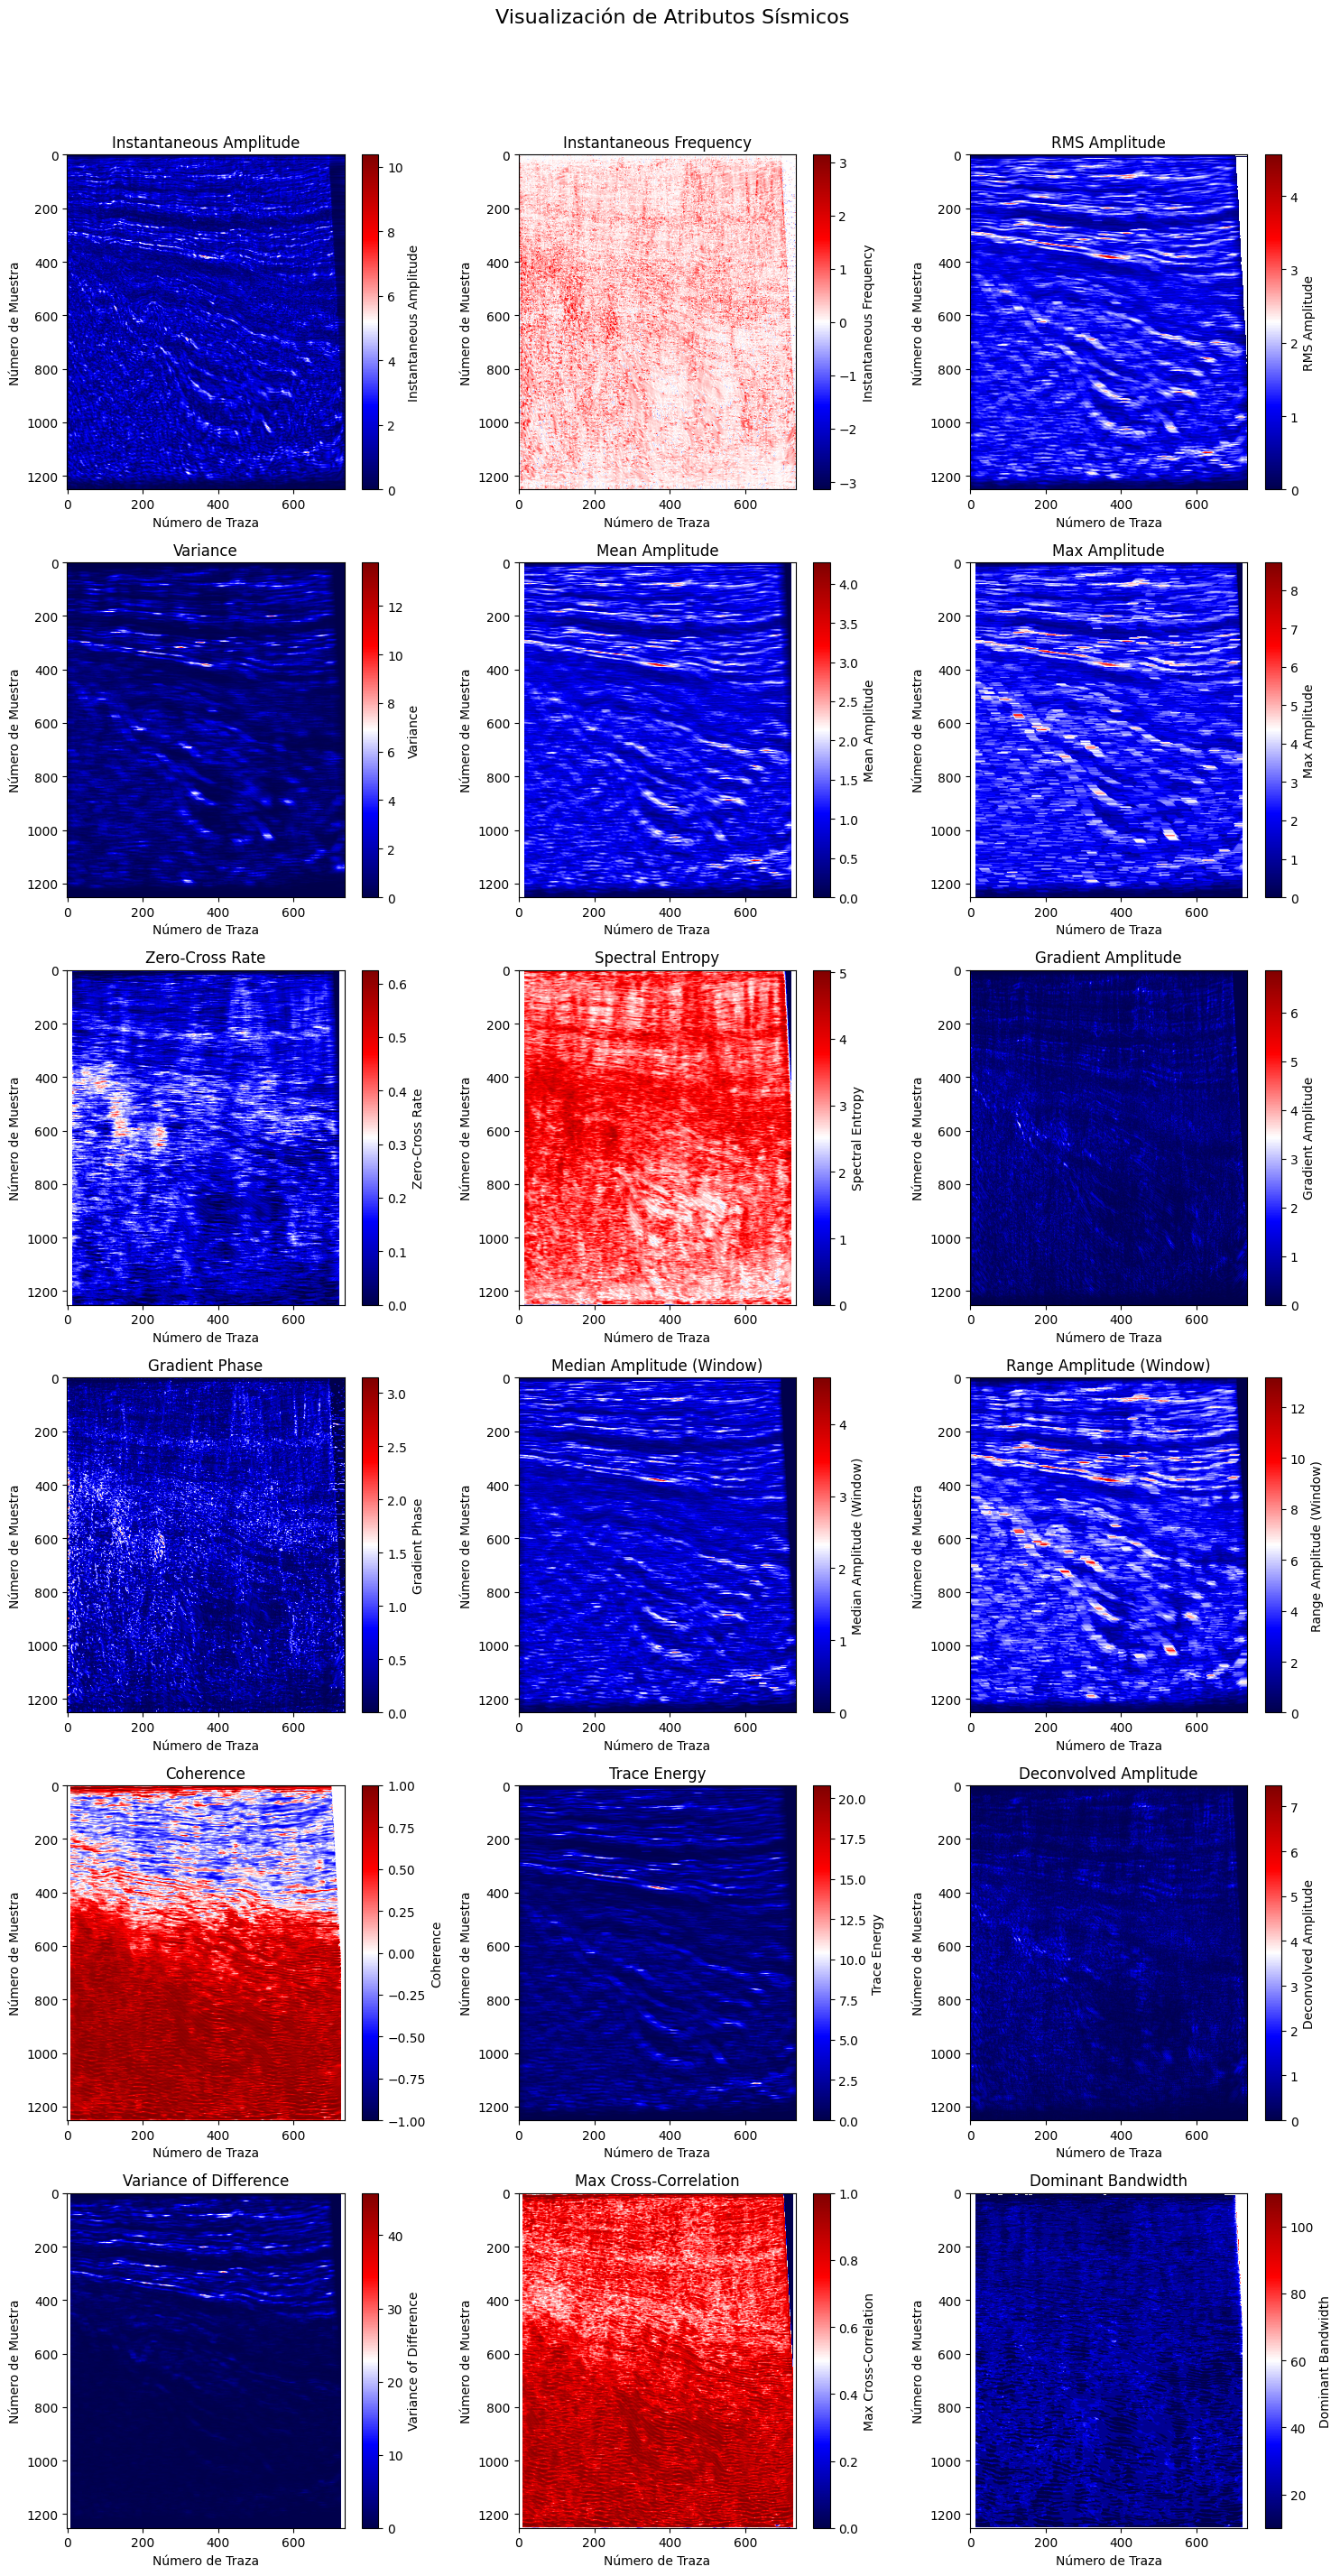

In [235]:
if 'attributes' in locals():
    # --- Visualizar los atributos en subplots ---
    num_attributes = len(attributes)
    rows = (num_attributes + 2) // 3  # Calcular el número de filas necesario
    cols = min(num_attributes, 3)      # Mostrar hasta 3 columnas

    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    fig.suptitle('Visualización de Atributos Sísmicos', fontsize=16)

    i = 0
    for name, attribute_matrix in attributes.items():
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        im = ax.imshow(attribute_matrix.T, aspect='auto', cmap='seismic',)
        ax.set_title(name)
        ax.set_xlabel('Número de Traza')
        ax.set_ylabel('Número de Muestra')
        fig.colorbar(im, ax=ax, label=name)
        i += 1

    # Ocultar los subplots vacíos si el número de atributos no llena la cuadrícula
    if num_attributes < rows * cols:
        for j in range(num_attributes, rows * cols):
            fig.delaxes(axes.flatten()[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajustar para el título general
    plt.show()

else:
    print("⚠️ La variable 'attributes' no está definida. Asegúrate de ejecutar primero la celda de cálculo de atributos.")

In [236]:
import numpy as np

n_samples = 735
n_traces = 1252

# Crear arrays de coordenadas
sample_coords = np.arange(n_samples)
trace_coords = np.arange(n_traces)

# Crear una malla de coordenadas para cada punto
sample_grid, trace_grid = np.meshgrid(sample_coords, trace_coords, indexing='ij')

# Aplanar las matrices de coordenadas para que coincidan con la forma de nuestros atributos aplanados
flat_sample_coords = sample_grid.flatten()
flat_trace_coords = trace_grid.flatten()

print("Forma de las coordenadas aplanadas (muestras):", flat_sample_coords.shape)
print("Forma de las coordenadas aplanadas (trazas):", flat_trace_coords.shape)

Forma de las coordenadas aplanadas (muestras): (920220,)
Forma de las coordenadas aplanadas (trazas): (920220,)


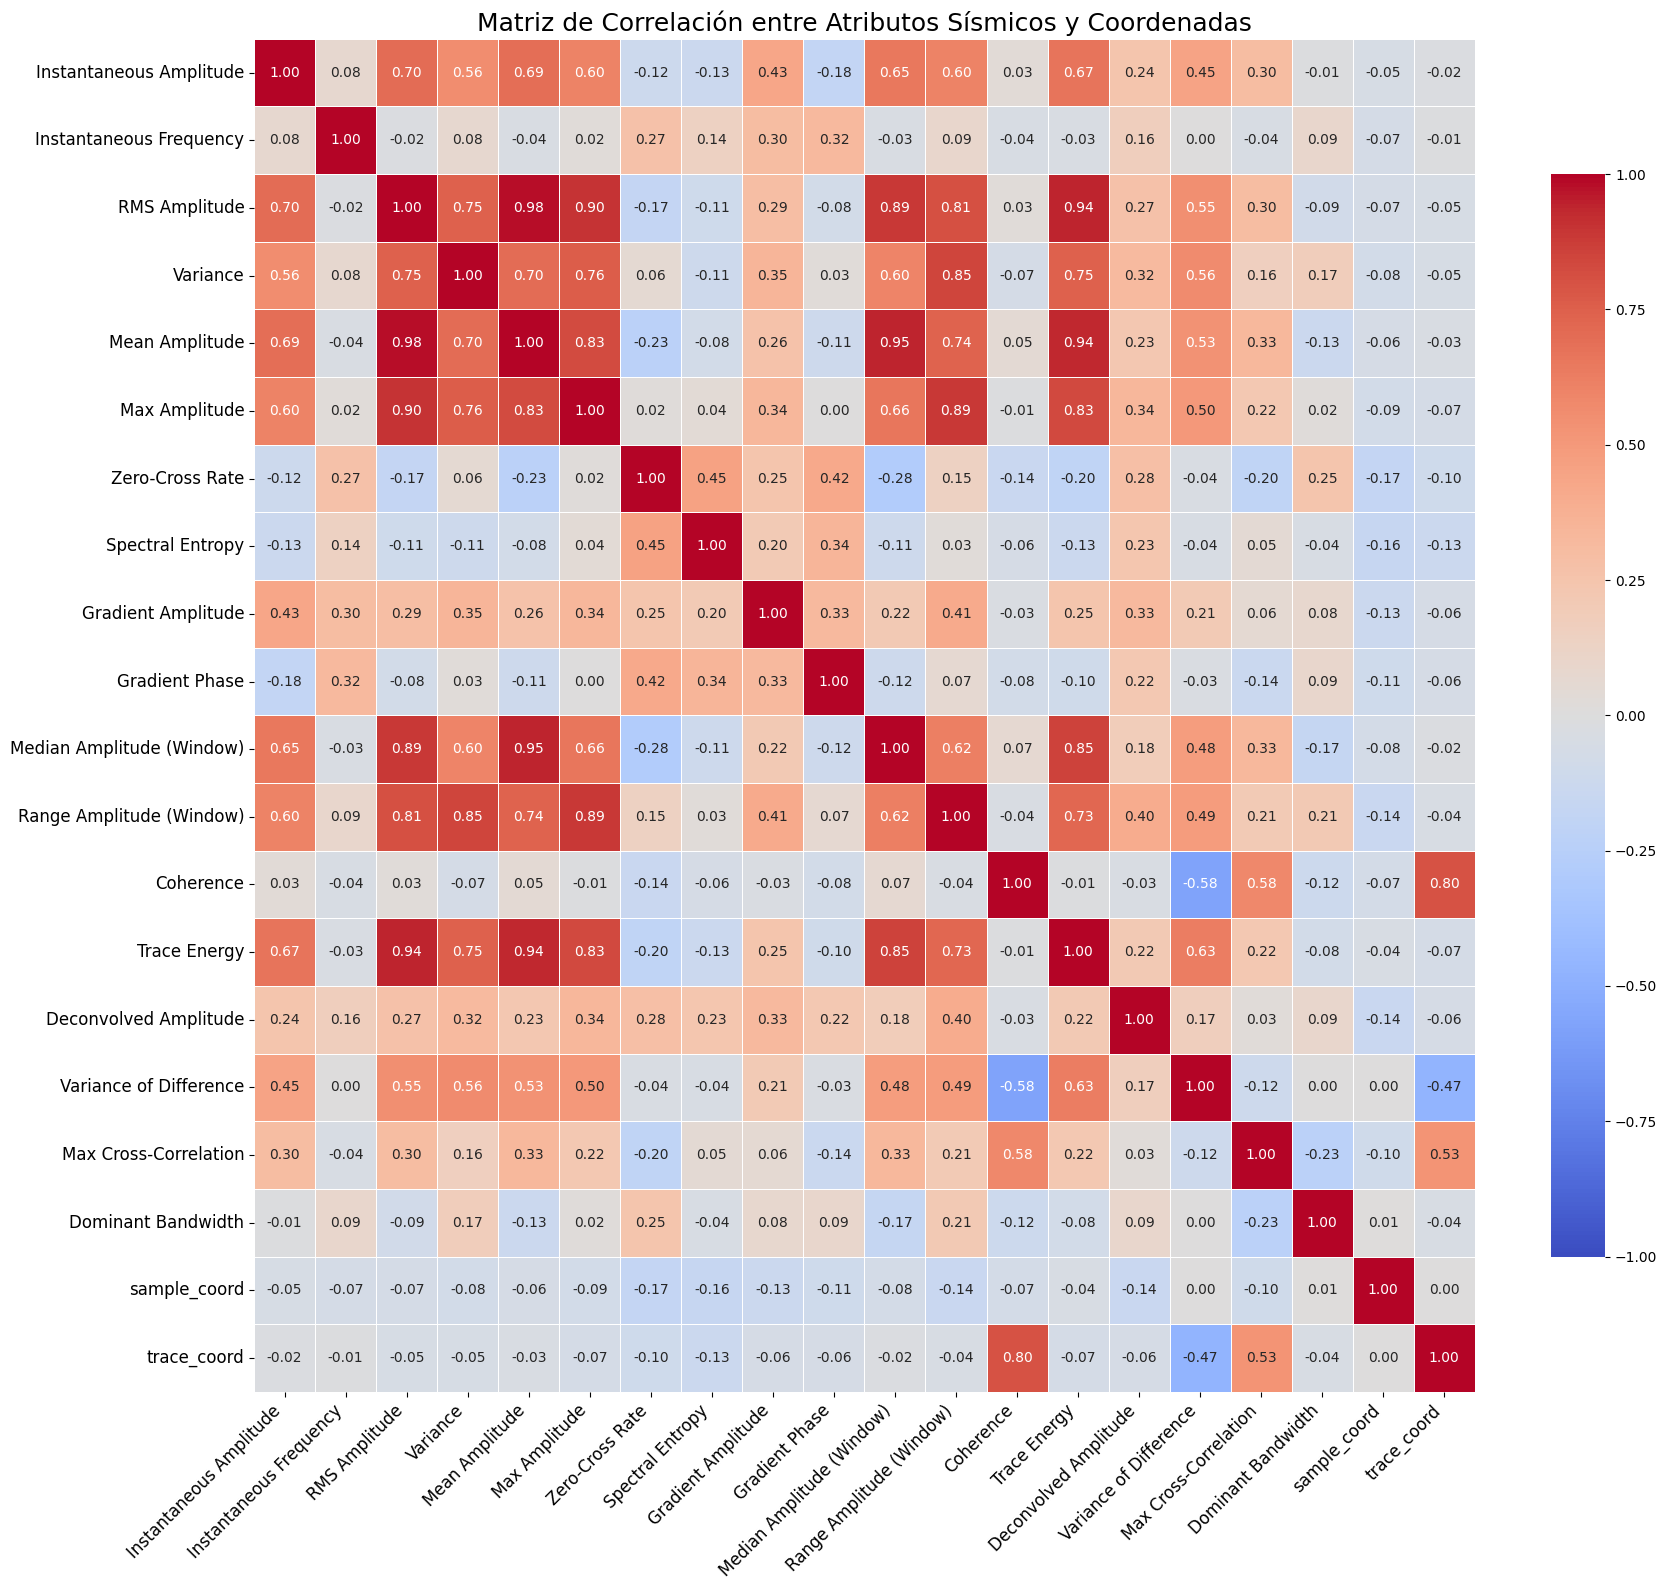

In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumiendo que la variable 'attributes' (diccionario con los atributos) ya está definida
# y que 'flat_sample_coords' y 'flat_trace_coords' también están definidas

# 1. Crear un diccionario para los datos del DataFrame
data_dict = {}
for name, attr in attributes.items():
    # Aplanar cada atributo 2D en una sola columna (manteniendo el orden)
    data_dict[name] = attr.flatten()

# Añadir las coordenadas como nuevos atributos AL DICCIONARIO
data_dict['sample_coord'] = flat_sample_coords
data_dict['trace_coord'] = flat_trace_coords

# 2. Crear el DataFrame a partir del diccionario
n_total_elements = list(attributes.values())[0].size
data_for_correlation = pd.DataFrame(data_dict, index=range(n_total_elements))

# 3. Calcular la matriz de correlación
correlation_matrix = data_for_correlation.corr()

# 4. Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(18, 16))  # Aumentamos el tamaño para que quepan las etiquetas
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'shrink': .8}, vmin=-1, vmax=1)
plt.title('Matriz de Correlación entre Atributos Sísmicos y Coordenadas', fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# COMPONENTES PRINCIPALES

In [238]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

# Asumiendo que ya tienes el diccionario 'attributes' con todos tus atributos
# y que 'flat_sample_coords' y 'flat_trace_coords' están definidas

# 1. Crear un diccionario para los datos del DataFrame
data_dict = {}
for name, attr in attributes.items():
    data_dict[name] = attr.flatten()

# Añadir las coordenadas como nuevos atributos AL DICCIONARIO
data_dict['sample_coord'] = flat_sample_coords
data_dict['trace_coord'] = flat_trace_coords

# 2. Crear el DataFrame a partir del diccionario
num_samples = list(attributes.values())[0].shape[0] * list(attributes.values())[0].shape[1]  # Total de puntos
data_for_pca_spatial = pd.DataFrame(data_dict, index=range(num_samples))

# 3. Inicializar el StandardScaler
scaler_spatial = StandardScaler()

# 4. Ajustar el scaler a tus datos (incluyendo coordenadas) y transformarlos
scaled_data_spatial = scaler_spatial.fit_transform(data_for_pca_spatial)

# 'scaled_data_spatial' ahora es un array NumPy con tus atributos Y coordenadas escalados

print("Forma de los datos escalados (con coordenadas):", scaled_data_spatial.shape)
print("Primeras 5 filas de los datos escalados (con coordenadas):\n", scaled_data_spatial[:5])

Forma de los datos escalados (con coordenadas): (920220, 20)
Primeras 5 filas de los datos escalados (con coordenadas):
 [[-1.5789094  -0.54651378 -2.29609139 -1.0747998          nan         nan
          nan         nan -0.9979424  -0.96175813 -1.81733886 -2.18153192
          nan -1.10961752 -1.01280934         nan         nan         nan
  -1.72969588 -1.73066793]
 [-1.5789094  -0.54651378 -2.29609139 -1.0747998          nan         nan
          nan         nan -0.9979424  -0.96175813 -1.81733886 -2.18153192
          nan -1.10961752 -1.01280934         nan         nan         nan
  -1.72969588 -1.72790108]
 [-1.5789094  -0.54651378 -2.29609139 -1.0747998          nan         nan
          nan         nan -0.9979424  -0.96175813 -1.81733886 -2.18153192
          nan -1.10961752 -1.01280934         nan         nan         nan
  -1.72969588 -1.72513422]
 [-1.5789094  -0.54651378 -2.29609139 -1.0747998          nan         nan
          nan         nan -0.9979424  -0.96175813 -1.81733

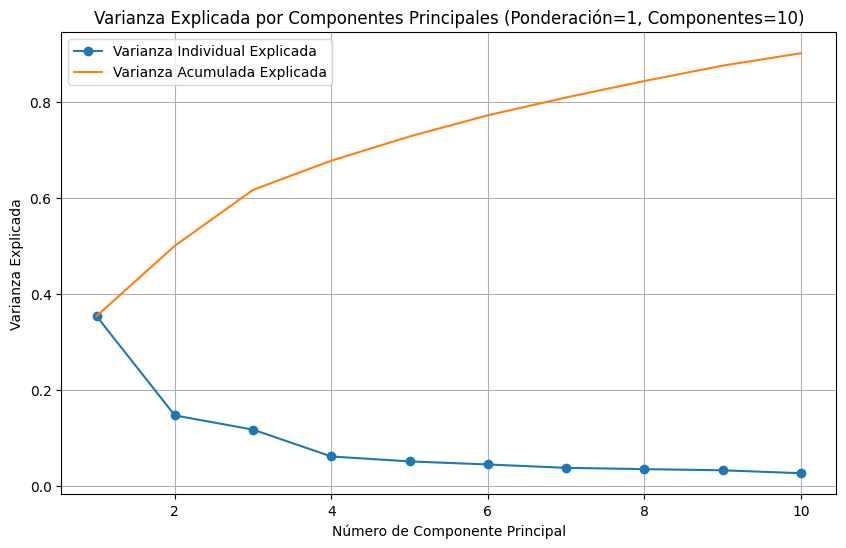

Factor de ponderación espacial: 1
Número de componentes principales: 10
Varianza explicada por cada componente (con ponderación): [0.35321935 0.14638298 0.11663799 0.06076528 0.05047408 0.04408355
 0.03708375 0.03438563 0.03194541 0.02586994]
Varianza acumulada explicada (con ponderación): [0.35321935 0.49960233 0.61624032 0.6770056  0.72747968 0.77156323
 0.80864698 0.84303262 0.87497803 0.90084797]


In [242]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Asumiendo que 'attributes', 'flat_sample_coords' y 'flat_trace_coords' ya están definidas

# --- ¡VARIABLES PARA MODIFICAR! ---
spatial_weight = 1  # Factor de ponderación para las coordenadas espaciales
n_components =10     # Número de componentes principales a conservar
# --- ¡VARIABLES PARA MODIFICAR! ---

# 1. Crear un diccionario para los datos del DataFrame (con coordenadas ponderadas)
data_dict_weighted = {}
for name, attr in attributes.items():
    data_dict_weighted[name] = attr.flatten()

# Añadir las coordenadas ponderadasA
data_dict_weighted['weighted_sample_coord'] = flat_sample_coords * spatial_weight
data_dict_weighted['weighted_trace_coord'] = flat_trace_coords * spatial_weight

# 2. Crear el DataFrame a partir del diccionario
num_samples = list(attributes.values())[0].shape[0] * list(attributes.values())[0].shape[1]
data_for_pca_weighted = pd.DataFrame(data_dict_weighted, index=range(num_samples))

# 3. Inicializar el SimpleImputer
imputer_weighted = SimpleImputer(strategy='mean')

# 4. Ajustar el imputer a los datos ponderados y transformarlos
imputed_data_weighted = imputer_weighted.fit_transform(data_for_pca_weighted)

# 5. Inicializar el StandardScaler
scaler_weighted = StandardScaler()

# 6. Ajustar el scaler a los datos imputados y transformarlos
scaled_data_imputed_weighted = scaler_weighted.fit_transform(imputed_data_weighted)

# 7. Inicializar PCA con el número de componentes especificado
pca_weighted = PCA(n_components=n_components)

# 8. Ajustar PCA a los datos escalados e imputados Y TRANSFORMAR los datos
principal_components_weighted = pca_weighted.fit_transform(scaled_data_imputed_weighted)

# 9. Analizar la varianza explicada por cada componente
explained_variance_ratio_weighted = pca_weighted.explained_variance_ratio_
cumulative_variance_ratio_weighted = np.cumsum(explained_variance_ratio_weighted)

# 10. Graficar la varianza explicada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio_weighted) + 1), explained_variance_ratio_weighted, marker='o', label='Varianza Individual Explicada')
plt.plot(range(1, len(cumulative_variance_ratio_weighted) + 1), cumulative_variance_ratio_weighted, linestyle='-', label='Varianza Acumulada Explicada')
plt.xlabel('Número de Componente Principal')
plt.ylabel('Varianza Explicada')
plt.title(f'Varianza Explicada por Componentes Principales (Ponderación={spatial_weight}, Componentes={n_components})')
plt.grid(True)
plt.legend()
plt.show()

print("Factor de ponderación espacial:", spatial_weight)
print("Número de componentes principales:", n_components)
print("Varianza explicada por cada componente (con ponderación):", explained_variance_ratio_weighted)
print("Varianza acumulada explicada (con ponderación):", cumulative_variance_ratio_weighted)

# Ahora, recuerda ejecutar la celda de K-Means y la de visualización con los nuevos componentes principales
# obtenidos de 'principal_components_weighted'

In [251]:
from sklearn.cluster import KMeans
import numpy as np

# Asumiendo que 'scaled_data_imputed_weighted' ya está definido y que aplicaste PCA a él
# y obtuviste 'principal_components_weighted'

# Especificar el número de clusters (mantenemos 3 por ahora, puedes ajustarlo)
n_clusters_weighted = 3

# Inicializar el modelo K-Means
kmeans_weighted = KMeans(n_clusters=n_clusters_weighted, random_state=42, n_init='auto')

# Ajustar el modelo a los NUEVOS componentes principales (con ponderación espacial)
cluster_labels_weighted = kmeans_weighted.fit_predict(scaled_data_imputed_weighted)

# Remodelar las etiquetas a la forma de la sísmica 2D para la visualización
cluster_map_weighted = cluster_labels_weighted.reshape((735, 1252))

print("Etiquetas de los clusters (con ponderación espacial, primeros 20):", cluster_labels_weighted[:20])
print("Número total de puntos:", len(cluster_labels_weighted))
print("Número de clusters encontrados:", len(np.unique(cluster_labels_weighted)))

# Recuerda ejecutar la celda de visualización después de esta

Etiquetas de los clusters (con ponderación espacial, primeros 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Número total de puntos: 920220
Número de clusters encontrados: 3


In [243]:
from sklearn.cluster import Birch
import numpy as np

# Asumiendo que 'scaled_data_imputed_weighted' ya está definido y que aplicaste PCA a él
# y obtuviste 'principal_components_weighted'

# Definir los parámetros para BIRCH
# threshold: El radio del subcluster obtenido al agrupar una nueva muestra.
# branching_factor: Número máximo de subclusters en cada nodo no hoja.
# n_clusters: Número final de clusters después de la fase de reducción. Si es None, se deja a la fase de clustering final.
threshold_birch = 3.3    # ¡Este es un parámetro importante para ajustar! Prueba con diferentes valores (ej: 0.1, 1.0, 2.0)
branching_factor_birch = 200 # Puedes ajustar este valor (ej: 25, 100)
n_clusters_birch = None   # Puedes especificar un número (ej: 10, 20) o dejar que BIRCH lo determine

# Inicializar el modelo BIRCH
birch_algorithm = Birch(threshold=threshold_birch, branching_factor=branching_factor_birch, n_clusters=n_clusters_birch)

# Ajustar el modelo a los componentes principales (con ponderación espacial) y obtener las etiquetas de los clusters
cluster_labels_birch = birch_algorithm.fit_predict(principal_components_weighted)

# Remodelar las etiquetas a la forma de la sísmica 2D para la visualización
cluster_map_birch = cluster_labels_birch.reshape((735, 1252))

print("Etiquetas de los clusters BIRCH (primeros 20):", cluster_labels_birch[:20])
print("Número total de puntos:", len(cluster_labels_birch))
print("Número de clusters encontrados:", len(np.unique(cluster_labels_birch)))

# Recuerda ejecutar la celda de visualización después de esta, ajustando la variable del mapa de clusters

Etiquetas de los clusters BIRCH (primeros 20): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Número total de puntos: 920220
Número de clusters encontrados: 183


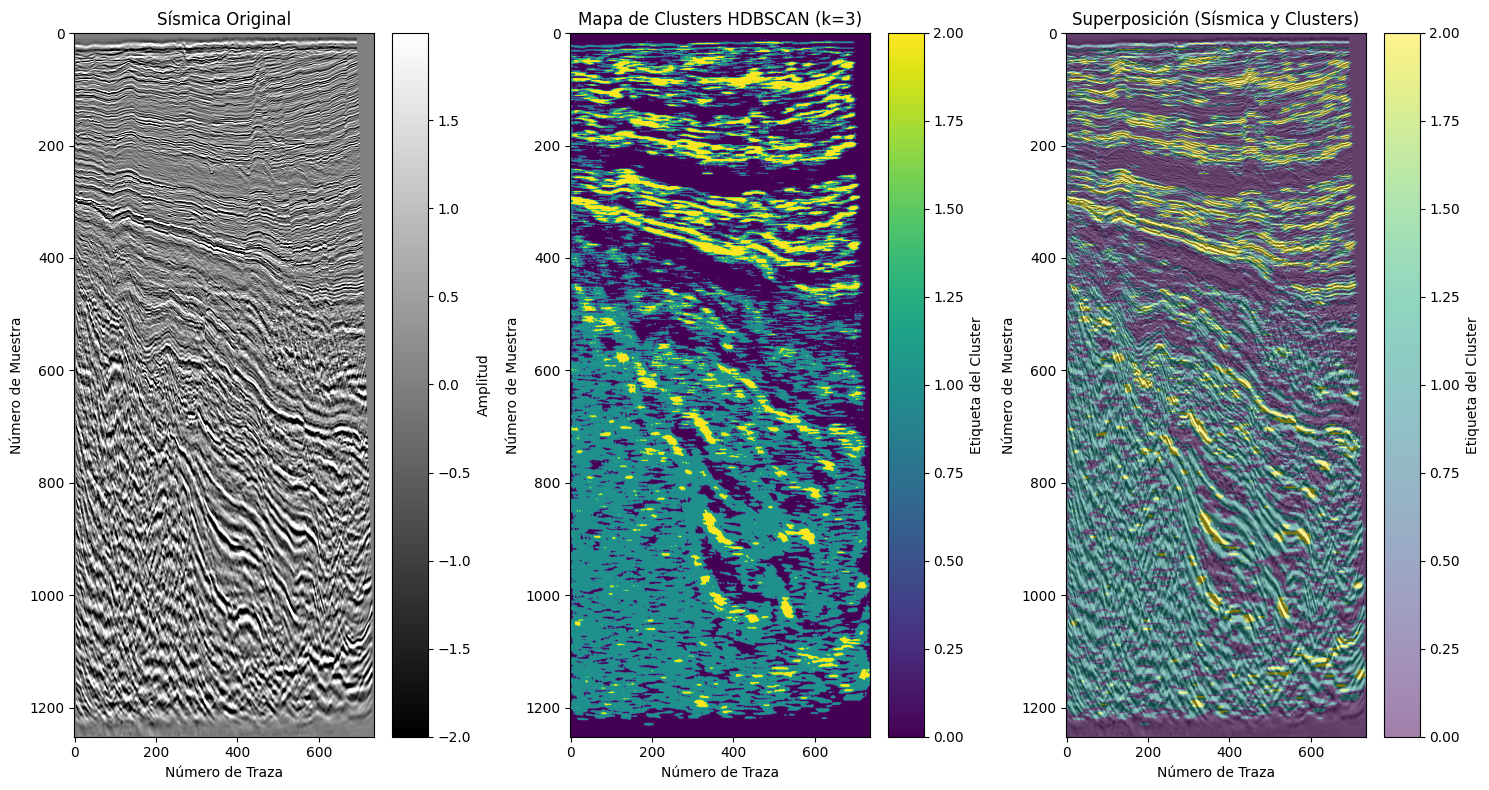

In [252]:
import matplotlib.pyplot as plt
import numpy as np

# Asumiendo que tienes 'seismic2d' y 'cluster_map_hdbscan'

n_samples, n_traces = seismic2d.shape
n_clusters_hdbscan = np.unique(cluster_map_weighted).size

# 1. Graficar la sísmica original (transpuesta)
plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.imshow(seismic2d.T, aspect='auto', cmap='gray', vmin=np.percentile(seismic2d, 5), vmax=np.percentile(seismic2d, 95))
plt.title('Sísmica Original')
plt.xlabel('Número de Traza')
plt.ylabel('Número de Muestra')
plt.colorbar(label='Amplitud')

# 2. Graficar el mapa de clusters (transpuesto) con un colormap diferente
plt.subplot(1, 3, 2)
plt.imshow(cluster_map_weighted.T, aspect='auto', cmap='viridis')  # Cambiamos a 'viridis'
plt.title(f'Mapa de Clusters HDBSCAN (k={n_clusters_hdbscan})')
plt.xlabel('Número de Traza')
plt.ylabel('Número de Muestra')
plt.colorbar(label='Etiqueta del Cluster')

# 3. Graficar la superposición de sísmica y clusters con transparencia (transpuestos)
plt.subplot(1, 3, 3)
plt.imshow(seismic2d.T, aspect='auto', cmap='gray', alpha=1, vmin=np.percentile(seismic2d, 5), vmax=np.percentile(seismic2d, 95))
plt.imshow(cluster_map_weighted.T, aspect='auto', cmap='viridis', alpha=0.5) # Cambiamos a 'viridis'
plt.title('Superposición (Sísmica y Clusters)')
plt.xlabel('Número de Traza')
plt.ylabel('Número de Muestra')
plt.colorbar(label='Etiqueta del Cluster')

plt.tight_layout()
plt.show()